#### Загружаю библиотеки


In [75]:
import pandas as pd
import numpy as np
import scipy.stats as ss
from scipy.stats import shapiro, chi2_contingency, mannwhitneyu, kruskal

import statsmodels.api as sa
import statsmodels.formula.api as sfa
import scikit_posthocs as sp

import seaborn as sns 
import matplotlib.pyplot as plt


#### Подгружаю данные

In [5]:
df = pd.read_csv('churn.csv')
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


#### Проверяю пропущенные значения и тип данных


In [20]:
df.isna().sum()

avg_dist                     0
avg_rating_by_driver       201
avg_rating_of_driver      8122
avg_surge                    0
city                         0
last_trip_date               0
phone                      396
signup_date                  0
surge_pct                    0
trips_in_first_30_days       0
luxury_car_user              0
weekday_pct                  0
dtype: int64

In [21]:
df.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
luxury_car_user                     bool
weekday_pct                      float64
dtype: object

#### Колонки last_trip_date и signup_date имеют тип object, поэтому необходимо перевести их в формат даты

In [13]:
df['last_trip_date'] = pd.to_datetime(df.last_trip_date)
df['signup_date'] = pd.to_datetime(df.signup_date)

In [14]:
df.dtypes

avg_dist                         float64
avg_rating_by_driver             float64
avg_rating_of_driver             float64
avg_surge                        float64
city                              object
last_trip_date            datetime64[ns]
phone                             object
signup_date               datetime64[ns]
surge_pct                        float64
trips_in_first_30_days             int64
luxury_car_user                     bool
weekday_pct                      float64
dtype: object

In [18]:
df.describe(include = 'object')

,city,phone
count,50000,49604
unique,3,2
top,Winterfell,iPhone
freq,23336,34582


In [19]:
df.describe(include = 'datetime')

/tmp/ipykernel_76/515801629.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df.describe(include = 'datetime')


,last_trip_date,signup_date
count,50000,50000
unique,182,31
top,2014-06-29 00:00:00,2014-01-18 00:00:00
freq,2036,2948
first,2014-01-01 00:00:00,2014-01-01 00:00:00
last,2014-07-01 00:00:00,2014-01-31 00:00:00


### Чтобы проанализировать отток водителей (churn), необходимо сначала определиться каких водитилей считать "отвалившимися". В качестве допущения предположим, что клиент будет считаться "отвалившимся", если он не пользовался нашим приложением от 30 и более дней.  

In [30]:
df.last_trip_date.max()

Timestamp('2014-07-01 00:00:00')

Создаю новую колонку, которая показывает количество дней, которые прошли с момента последней поездки водителя

In [31]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date

In [32]:
df.days_since_last_trip

0        14 days
1        57 days
2       175 days
3         2 days
4       108 days
          ...   
49995    26 days
49996   157 days
49997    40 days
49998   167 days
49999    72 days
Name: days_since_last_trip, Length: 50000, dtype: timedelta64[ns]

Преобразую формат timedelta в int

In [33]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days

Создаю новую колонку churn, применив функцию lambda x, которая показывает, к какой группе относится тот или иной водитель - churn или not churn

In [38]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x>30 else 'not_churn')

In [39]:
df.churn

0        not_churn
1            churn
2            churn
3        not_churn
4            churn
           ...    
49995    not_churn
49996        churn
49997        churn
49998        churn
49999        churn
Name: churn, Length: 50000, dtype: object

Смотрю на распределение показателей

In [45]:
df.churn.value_counts(normalize=True).mul(100).round(1)

churn        62.4
not_churn    37.6
Name: churn, dtype: float64

#### 1. Гипотеза 1: Посмотреть на распределение оттока водителей в разрезе разных городов. Нулевая гипотеза (Н0) - различий в распределении нет.

/nfs/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='churn', ylabel='count'>

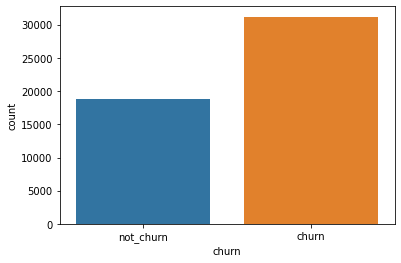

In [47]:
sns.countplot('churn', data=df)

/nfs/env/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='city', ylabel='count'>

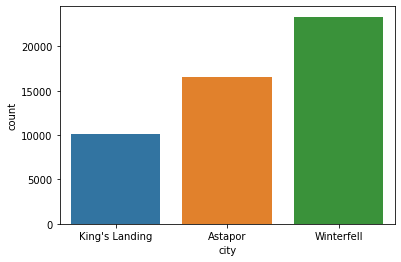

In [48]:
sns.countplot('city', data=df)

Поскольку переменные churn и city являются категориальными, то для проверки нулевой гипотезы я буду использовать хи-квадрат

Создаю таблицу сопряженности tab с помощью функции pd.crosstab, для выражения связи между двумя категориальными переменными

In [49]:
tab = pd.crosstab(df.churn, df.city)
print(tab)

city       Astapor  King's Landing  Winterfell
churn                                         
churn        12306            3767       15123
not_churn     4228            6363        8213


Критерий хи-квадрат

In [53]:
stat, p, dof, expected = chi2_contingency(tab)

print(p)

0.0


#### ВЫВОД: нулевая гипотеза отклоняется, т.к pvalue<0.05, следовательно различия в распределении оттока водителей в разрезе городов есть

#### 2. Гипотеза 2: Посмотреть на распределение активности в первые 30 дней с момента регистрации (trips_in_first_30_days) между водителями из разных городов (city). Нулевая гипотеза (Н0) - различий в активности нет.

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trips_in_first_30_days', ylabel='Density'>

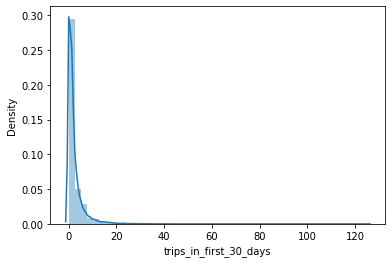

In [55]:
sns.distplot(df.trips_in_first_30_days)

Проверряем нормальность распределения переменной trips_in_first_30_days в разрезе городов

In [69]:
ast = df[df.city == 'Astapor'].trips_in_first_30_days
king = df[df.city == "King's Landing"].trips_in_first_30_days
winter = df[df.city == 'Winterfell'].trips_in_first_30_days

Тест Шапиро-Уиалка для проверки нормальности распределения переменной trips_in_first_30_days

In [70]:
print(shapiro(ast.sample(1000, random_state=17)))
print(shapiro(king.sample(1000, random_state=17)))
print(shapiro(winter.sample(1000, random_state=17)))

ShapiroResult(statistic=0.5414707660675049, pvalue=4.203895392974451e-45)
ShapiroResult(statistic=0.6132159233093262, pvalue=1.6829594556541053e-42)
ShapiroResult(statistic=0.5455795526504517, pvalue=7.006492321624085e-45)


#### ВЫВОД: во всех трех случаях, pvalue очень маленькое, следовательно можно отклонять Н0 гипотезу о нормальном распределении. Поэтому исплльзуем непараметрический аналог ANOVA - КРИТЕРИЙ КРАСКЕЛА-УОЛЛИСА

#### 3. Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days) Обнаружены ли статистически значимые различия?

Критерий Краскела-Уоллиса

In [72]:
kr_res = kruskal(ast, king, winter)
print(kr_res)

KruskalResult(statistic=221.32105325317454, pvalue=8.724567791938856e-49)


#### p_value < 0.05, следовательно обнаружены стат.значимые различия. С помощью posthoc_dunn можно выяснить где конкретно существуют различия

In [76]:
dat = [ast, king, winter]
sp.posthoc_dunn(dat, p_adjust = 'holm')

,1,2,3
1,1.000000e+00,1.313616e-09,2.448501e-49
2,1.313616e-09,1.000000e+00,8.440212e-10
3,2.448501e-49,8.440212e-10,1.000000e+00


#### ВЫВОД: все три группы значимо друг от друга отличаются

#### 4. Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

In [77]:
# переменная churn характерезует активность отвалившихся пользователей в течение первых 30 дней после регистрации
churn = df[df.churn == 'churn'].trips_in_first_30_days

# переменная not churn - тоже самое, но для тех пользователей, которые остались
not_churn = df[df.churn == 'not_churn'].trips_in_first_30_days

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trips_in_first_30_days', ylabel='Density'>

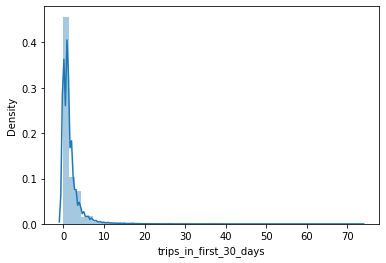

In [79]:
sns.distplot(churn)

/nfs/env/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='trips_in_first_30_days', ylabel='Density'>

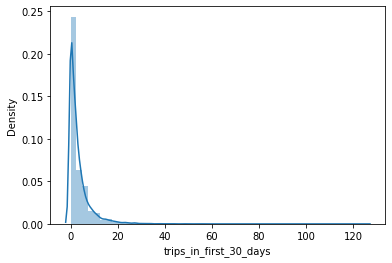

In [80]:
sns.distplot(not_churn)

Видно, что оба распределения переменной trips_in_first_30_days не являются нормальными, следовательно для проверки гипотезы использую U-критерий Манна-Уитни

In [81]:
mannwhitneyu(churn, not_churn)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

pvalue < 0.05, следовательно результат оказался стат.значимым. Выясним какого именно характера различия мы имеем

<AxesSubplot:xlabel='churn', ylabel='trips_in_first_30_days'>

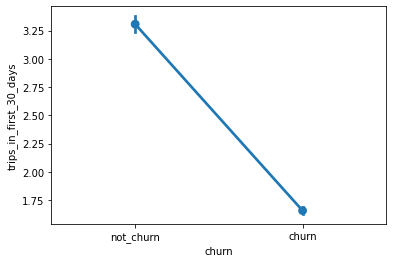

In [82]:
sns.pointplot(x = 'churn', y = 'trips_in_first_30_days', data = df)

#### ВЫВОД: Распределение переменной trips_in_first_30_days НЕ ЯВЛЯЕТСЯ НОРМАЛЬНЫМ, поэтому для проверки гипотезы я использую U-КРИТЕРИЙ МАННА-УИТНИ. Результат оказался статистически значим. Значит, значимые различия есть, ушедшие пользователи были менее активны.